In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import csv as csv

# /Users/hayatoyamaguchi/Public/kaggle/House Price/house-prices-advanced-regression-techniques

path = "house-prices-advanced-regression-techniques/"
train_df = pd.read_csv(path+"train.csv", header=0)
test_df = pd.read_csv(path+"test.csv", header=0)
train_df['WhatIsData'] = 'Train'
test_df['WhatIsData'] = 'Test'
train_df.tail()

for i in range(1,10):
    train_df["OverallQual"+str(i)] = 0
    train_df.loc[train_df["OverallQual"]==i,"OverallQual"+str(i)] = 1
    test_df["OverallQual"+str(i)] = 0
    test_df.loc[test_df["OverallQual"]==i,"OverallQual"+str(i)] = 1
test_df.tail()

drop_train_df = train_df.drop('SalePrice',axis=1)
allData = pd.concat([drop_train_df,test_df],axis=0)
allData['TotalSF'] = allData['TotalBsmtSF'] + allData['1stFlrSF'] + allData['2ndFlrSF']

allData["LotFrontage"] = allData.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
na_col_list = allData.isnull().sum()[allData.isnull().sum()>0].sort_values(ascending=False).index.tolist()
for row in na_col_list:
    if allData[row].dtypes == "float64":
        allData[row][allData[row].isnull()] = 0
    else:
        allData[row][allData[row].isnull()] = "NA"

dropData = allData[allData.columns[allData.columns != "WhatIsData"]]

data_dummies = pd.get_dummies(dropData)
transdropData = pd.concat([dropData,data_dummies],axis=1)

transdropData = transdropData.select_dtypes(include=["float64","int64","uint8"])
transdropData = transdropData.astype('int')
a = transdropData.select_dtypes(include="object")

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
columns = transdropData.columns.values
transdropData_scaled = pd.DataFrame(scaler.fit(transdropData).transform(transdropData),columns=columns)

# transAllData = pd.concat([transdropData_scaled,allData["WhatIsData"]],axis=1)

transdropData_scaled["WhatIsData"] = list(allData["WhatIsData"])
transAllData = transdropData_scaled

from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(train_df["SalePrice"])


transAllData2 = transAllData.loc[:,~transAllData.columns.duplicated()]

X_train = transAllData2[transAllData2['WhatIsData']=='Train'].drop(['WhatIsData','Id'], axis=1)
y_train = np.log(train_df["SalePrice"])
X_test = transAllData2[transAllData2['WhatIsData']=='Test'].drop(['WhatIsData','Id'], axis=1)

X_train["Interaction"] = X_train["TotalSF"]*X_train["OverallQual"]
X_test["Interaction"] = X_test["TotalSF"]*X_test["OverallQual"]

print(X_train.shape)
X_test.head()

Xmat = X_train
Xmat['SalePrice'] = y_train
Xmat = Xmat.drop(Xmat[(Xmat['TotalSF']>5) & (Xmat['SalePrice']<12.5)].index)
Xmat = Xmat.drop(Xmat[(Xmat['GrLivArea']>5) & (Xmat['SalePrice']<13)].index)

# recover
y_train = Xmat['SalePrice']
X_train = Xmat.drop(['SalePrice'], axis=1)

/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(1460, 322)


/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.


In [22]:
from sklearn.linear_model import LinearRegression,Ridge
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


xgbr = xgb.XGBRegressor(max_depth=3,learning_rate=0.1,colsample_bytree=0.9)
xgbr.fit(X_train,y_train)

svr = SVR(C=3,gamma=0.001)
svr.fit(X_train,y_train)

lr = LinearRegression()
lr.fit(X_train,y_train)

ridge = Ridge(alpha=30)
ridge.fit(X_train,y_train)

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(random_state=0,min_samples_split=5,n_estimators=700,max_depth=4)
forest.fit(X_train,y_train)

# X_train2 = pd.DataFrame({"XGB":xgbr.predict(X_train),"SVR":svr.predict(X_train)
#                          ,"Linear":lr.predict(X_train),"Ridge":ridge.predict(X_train)})
# X_train2 = pd.DataFrame({"XGB":xgbr.predict(X_train),"SVR":svr.predict(X_train)
#                          ,"Linear":lr.predict(X_train),"Ridge":ridge.predict(X_train),"Forest":forest.predict(X_train)})
X_train2 = pd.DataFrame({"XGB":xgbr.predict(X_train),"SVR":svr.predict(X_train)
                         ,"Ridge":ridge.predict(X_train),"Forest":forest.predict(X_train)})

X_train2.head()

/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/hayatoyamaguchi/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,XGB,SVR,Ridge,Forest
0,12.244248,12.211633,12.235309,12.175016
1,12.093943,12.208892,12.193418,12.052227
2,12.269696,12.228523,12.275460,12.207090
3,11.938777,11.949452,12.012305,12.031044
4,12.551652,12.529649,12.564459,12.495373


In [23]:
from sklearn import linear_model
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train2_train,X_val2,y_train2_train,y_val2 = train_test_split(X_train2,y_train,random_state=0)


reg = linear_model.LinearRegression()
reg.fit(X_train2_train,y_train2_train)
# reg.score()
print(y_train2_train.shape)
print(X_train2_train.shape)
print(np.sqrt(mean_squared_error(y_train2_train ,reg.predict(X_train2_train))))
print(np.sqrt(mean_squared_error(y_val2,reg.predict(X_val2))))
print(reg.coef_)

(1093,)
(1093, 4)
0.07120159847056874
0.06746152051141334
[ 0.61454547  0.72659147 -0.13543855 -0.20949987]


In [25]:
# X_test2 = pd.DataFrame({"XGB":xgbr.predict(X_test),"SVR":svr.predict(X_test)
#                          ,"Linear":lr.predict(X_test),"Ridge":ridge.predict(X_test)})
# X_test2 = pd.DataFrame({"XGB":xgbr.predict(X_test),"SVR":svr.predict(X_test)
#                          ,"Linear":lr.predict(X_test),"Ridge":ridge.predict(X_test),"Forest":forest.predict(X_test)})
X_test2 = pd.DataFrame({"XGB":xgbr.predict(X_test),"SVR":svr.predict(X_test)
                         ,"Ridge":ridge.predict(X_test),"Forest":forest.predict(X_test)})
X_test2

,XGB,SVR,Ridge,Forest
0,11.702616,11.786576,11.692262,11.748050
1,12.003365,11.969460,12.001488,11.942740
2,12.118504,12.147814,12.135181,12.044540
3,12.147856,12.240962,12.212133,12.079149
4,12.148664,12.205769,12.176590,12.174428
5,12.036246,12.075585,12.050541,12.068827
6,12.053262,12.130433,12.077120,12.059268
7,12.024570,12.028299,12.000350,12.057353
8,12.172746,12.126131,12.176446,12.187182
9,11.708759,11.729726,11.689799,11.645967


0.9669890640998425
0.974398853444834


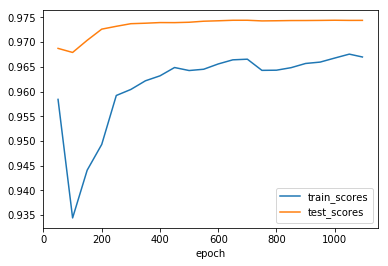

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train2_train,X_val,y_train2_train,y_val = train_test_split(X_train2,y_train,random_state=0)
# epochs = [100,200,300,400,500,600,700,800,900,1000,1095]
epochs = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000,1050,1095]
train_scores = []
test_scores = []
for epoch in epochs:
    model = LinearRegression()
    X_train_epoch = X_train2_train[:epoch]
    y_train_epoch = y_train2_train[:epoch]
#     print(X_train_epoch.shape)
#     print(y_train_epoch.shape)
    model.fit(X_train_epoch,y_train_epoch)
#     print(forest.score(X_train_epoch,y_train_epoch))
#     print(forest.score(X_val,y_val))
    train_scores.append(model.score(X_train_epoch,y_train_epoch))
    test_scores.append(model.score(X_val,y_val))
#     train_scores.append(np.sqrt(mean_squared_error(y_train_train ,model.predict(X_train_train))))
#     test_scores.append(np.sqrt(mean_squared_error(y_val,model.predict(X_val))))

    if epoch==1095:
#             print(np.sqrt(mean_squared_error(y_train_train ,model.predict(X_train_train))))
#             print(np.sqrt(mean_squared_error(y_val,model.predict(X_val))))
            print(model.score(X_train_epoch,y_train_epoch))
            print(model.score(X_val,y_val))
    
import matplotlib.pyplot as plt
%matplotlib inline
x = epochs
y0 = train_scores
y1 = test_scores
fig = plt.figure()
plt.xlabel('epoch')
plt.plot(x, y0, label='train_scores')
plt.plot(x, y1, label='test_scores')
plt.legend()
plt.show()

In [27]:
from datetime import datetime
time= datetime.now().strftime("%Y%m%d-%H%M%S")
model = LinearRegression()
model.fit(X_train2,y_train)
predictions = np.exp(model.predict(X_test2))
print(model.coef_)
df_result = pd.DataFrame()
df_result['Id'] = test_df['Id']
df_result['SalePrice'] = predictions
df_result.to_csv('result.csv'+time,index=False)
df_result



[ 0.60907293  0.70603122 -0.11938883 -0.19759098]


,Id,SalePrice
0,1461,127578.476817
1,1462,161684.085839
2,1463,189733.366161
3,1464,203006.234332
4,1465,195253.453721
5,1466,172401.982720
6,1467,180843.693528
7,1468,166932.737724
8,1469,186837.100761
9,1470,125562.092937
